## Image Semantics
In the previous notebook on [understanding modalities](understanding-modalities.ipynb), we explored how computers process images and how different models can be tailored to extract specific types of information based on our requirements.
Building on that foundation, computer vision offers several higher-level techniques that help us analyze what's actually happening within an image. Three fundamental approaches are object detection, segmentation, and tracking. These methods allow us to move beyond basic image understanding to identify specific elements and their precise locations within the visual data. This detailed spatial information becomes the building blocks for practical applications in autonomous vehicles, medical imaging, surveillance systems, and many other real-world domains.

## Key Techniques
- Object Detection: Locates and identifies objects within an image, typically by drawing bounding boxes around them
- Object Segmentation: Creates precise pixel-level boundaries around objects, showing their exact shapes rather than just rectangular boxes
- Object Tracking: Follows specific objects across multiple frames in a video sequence, maintaining consistent identification over time

In [1]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import supervision as sv
from ultralytics import YOLO
import torch

In [2]:
image_path = "./assets/crowded-city.jpg"

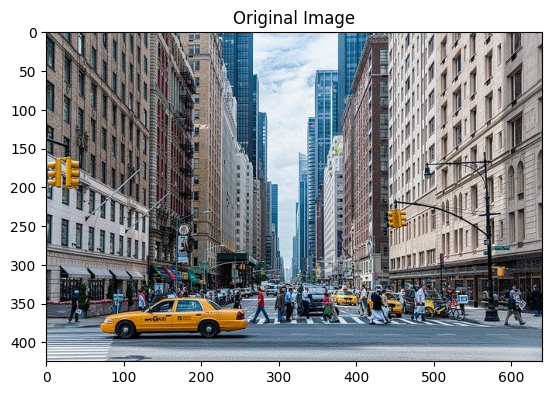

In [3]:
image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title("Original Image")
plt.imshow(image)
plt.show()

## Object Detection & Use-Cases

In [4]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
mask_annotator = sv.MaskAnnotator()

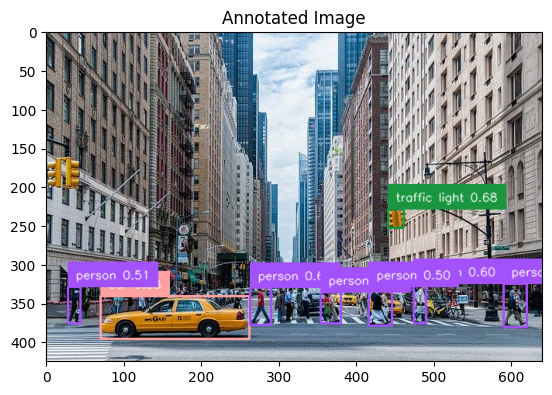

Sample detections: [[     70.044      341.78      262.26      396.65]
 [     441.84      229.38      461.48      253.12]
 [     263.42      330.35      290.14      378.29]
 [     474.42      325.99      490.35      376.19]
 [     590.07      325.88       620.9      381.03]]


In [8]:
# Initialising the models with pre-trained weights on the COCO dataset
# https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda

model = YOLO("yolo11n.pt")
image = cv2.imread(image_path)
results = model.predict(image, conf=0.5, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]
annotated_image = box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
color_corrected_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.title("Annotated Image")
plt.imshow(color_corrected_annotated_image)
plt.show()

print(f"Sample detections: {detections.xyxy[:5]}")

## Object Segmentation & Use-Cases

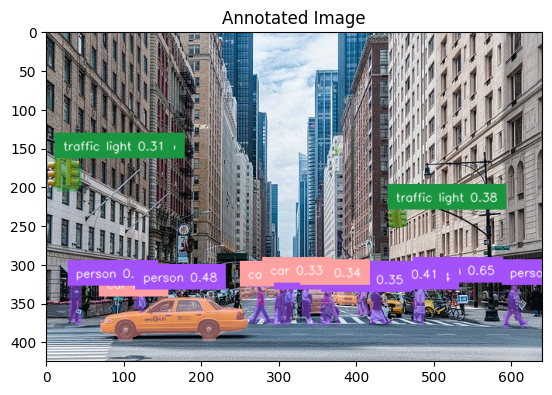

In [11]:
model = YOLO("yolov8n-seg.pt")
image = cv2.imread(image_path)

results = model.predict(image, conf=0.3, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]
annotated_image = mask_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
color_corrected_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

plt.title("Annotated Image")
plt.imshow(color_corrected_annotated_image)
plt.show()

### Object Tracking & Use-Cases

In [12]:
from IPython.display import Video

model = YOLO("yolov8n.pt")

def callback(frame: np.ndarray, _:int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    return box_annotator.annotate(frame.copy(), detections=detections)

Video("./assets/people-crossing-signal.mp4")

sv.process_video(
    source_path="./assets/people-crossing-signal.mp4",
    target_path="./assets/people-crossing-signal-output.mp4",
    callback=callback
)

Video("./assets/people-crossing-signal-output.mp4")


## Limitations of the approach

Most pre-trained models excel within their intended domains but struggle when applied to novel scenarios.

Adapting these models to new domains or specific use cases requires substantial labeled datasets - often thousands or tens of thousands of annotated examples. 

Ideally, the systems should adapt to new contexts as easily as human does. We can recognize objects we've never seen before by understanding their basic properties and relationships. 

    